<a href="https://colab.research.google.com/github/eginez/fastbook/blob/master/eginez_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests
!pip install -Uqq fastbook



     |████████████████████████████████| 727kB 8.4MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 194kB 39.0MB/s 
     |████████████████████████████████| 1.2MB 35.1MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 


In [2]:
import requests
import fastbook
from fastbook import *

def isearch_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass


In [10]:
imgs = isearch_images_ddg('audi a4')
print(imgs[0])


https://netcarflix.sfo2.digitaloceanspaces.com/2019/08/2020-Audi-A4-34.jpg


In [11]:
p = Path('imgs')
p.mkdir()
p.ls()

FileExistsError: ignored

In [18]:
len(imgs)
download_images(p,urls=imgs)


In [21]:
p.ls()
ff = get_image_files(p)
failed = verify_images(ff)
print(failed)
failed.map(Path.unlink)

[Path('imgs/00000106.jpg'), Path('imgs/00000028.jpg')]


(#2) [None,None]

In [26]:
def get_other_cars():
  urls = isearch_images_ddg('car')
  p = Path('cars')
  p.mkdir(exist_ok=True)
  download_images(p, urls=urls)
  return p
get_other_cars()

Path('cars')

In [35]:
cars = Path('cars')
ff = get_image_files(cars)
fl = verify_images(ff)
print(fl)
fl.map(Path.unlink)


[Path('cars/00000093.jpg')]


(#1) [None]

In [38]:
autos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

atl = autos.dataloaders(Path("../content"))

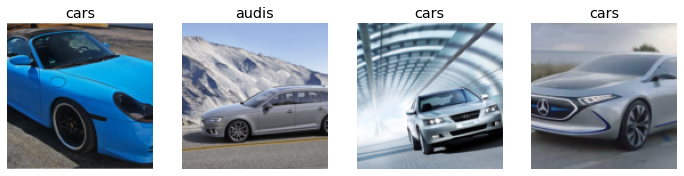

In [39]:
atl.valid.show_batch(max_n=4, nrows=1)

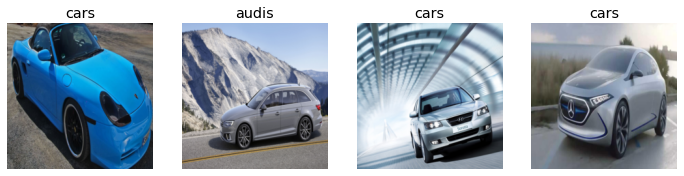

In [40]:
autos = autos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

atl = autos.dataloaders(Path("../content"))
atl.valid.show_batch(max_n=4, nrows=1)

In [41]:
learn = cnn_learner(atl, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.993950,0.702759,0.257143,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.603671,0.267469,0.142857,01:29
1,0.493681,0.196512,0.100000,01:29


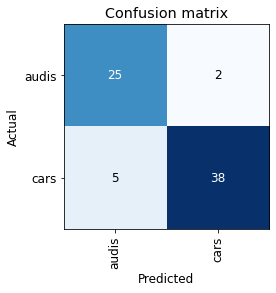

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

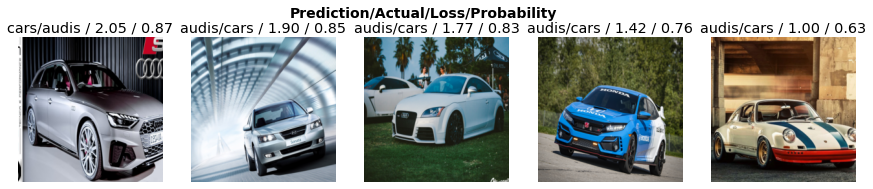

In [43]:
interp.plot_top_losses(5, nrows=1)


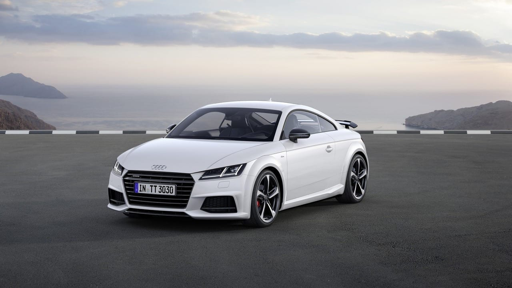

In [56]:
iv = isearch_images_ddg('audi tt')
pv = Path("validation")
pv.mkdir(exist_ok=True)
idx = random.randint(0, len(iv) - 1)
download_images(pv, urls=[iv[idx]])
Image.open(pv.ls()[0]).to_thumb(512,512)



In [57]:
learn.predict(pv.ls()[0])

('audis', tensor(0), tensor([0.8580, 0.1420]))